In [ ]:
!pip install transformers[sentencepiece] spacy rouge

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import torch
import re
import spacy
import nltk
import json
import en_core_web_lg
import pandas as pd
from tqdm import tqdm
from rouge import Rouge 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import AutoModelForMaskedLM, AutoModel, AutoTokenizer, pipeline

In [ ]:
nlp = en_core_web_lg.load()
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/My Drive


In [ ]:
f = open ('qa.json', "r")
qa = json.loads(f.read())

In [ ]:
qa['data'][0]

{'context': "Use acetaminophen exactly as directed on the label, or as prescribed by your doctor. Do not use in larger or smaller amounts or for longer than recommended.\nDo not take more of this medication than is recommended. An overdose of acetaminophen can damage your liver or cause death.\nAdults and teenagers who weigh at least 110 pounds (50 kilograms): Do not take more than 1000 milligrams (mg) at one time. Do not take more than 4000 mg in 24 hours.\nChildren younger than 12 years old: Do not take more than 5 doses of acetaminophen in 24 hours. Use only the number of milligrams per dose that is recommended for the child's weight and age. Use exactly as directed on the label.\nAvoid also using other medicines that contain acetaminophen, or you could have a fatal overdose.\nIf you are treating a child, use a pediatric form of acetaminophen. Use only the special dose-measuring dropper or oral syringe that comes with the specific pediatric form you are using. Carefully follow the d

In [ ]:
n_top = 3
rouge = Rouge()
smoothie = SmoothingFunction().method4
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougel_scores = []


model_names = {'bert-large-uncased-whole-word-masking-finetuned-squad':'question_answering',
               'ktrapeznikov/albert-xlarge-v2-squad-v2':'question_answering',
               'allenai/longformer-large-4096-finetuned-triviaqa':'question_answering',
               'deepset/roberta-large-squad2':'question_answering',
               'mrm8488/longformer-base-4096-finetuned-squadv2':'question_answering',
               'mrm8488/squeezebert-finetuned-squadv2':'question_answering',
               'bigwiz83/sapbert-from-pubmedbert-squad2':'question_answering',
               'vicgalle/xlm-roberta-large-xnli-anli':'similarity',
               'joeddav/xlm-roberta-large-xnli':'similarity',
               'valhalla/distilbart-mnli-12-3':'similarity',
               'BaptisteDoyen/camembert-base-xnli':'similarity',
               'typeform/mobilebert-uncased-mnli':'similarity',
               'valhalla/distilbart-mnli-12-1':'similarity',
               'valhalla/distilbart-mnli-12-9':'similarity',
               'cross-encoder/nli-distilroberta-base':'similarity',
               'bert-large-uncased':'similarity',
               'bert-large-cased':'similarity',
               'bert-base-uncased':'similarity',
               'bert-base-cased':'similarity',
               'bert-large-finetuned':'similarity',
               'bert-base-finetuned':'similarity'}

In [ ]:
class SentenceSimilarity():
    def __init__(self, model_name=None, device='cuda'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).eval()

    def __call__(self, text):
        tokens = self.tokenizer(text, padding=True, return_tensors='pt', truncation=True)
        with torch.no_grad():
            embeddings = self.model(**tokens).last_hidden_state

        mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.shape).float()
        sentence_embeddings = torch.sum(embeddings * mask, dim=1) / torch.clamp(mask.sum(1), min=1e-9) 
        return sentence_embeddings

    def compute_label_embedding(self, labels):
        self.label_embeds = self(labels)
    
    def similarity(self, example):
        return torch.cosine_similarity(self(example), self.label_embeds).tolist()

In [ ]:
def get_answer(sentences, question, model, model_type, n_top=None):
  if model_type == 'similarity':
    scores = model.similarity(question)
    dic = {}

    for i, ex in enumerate(sentences):
        dic[ex] = scores[i]

    s = pd.Series(dic, name='Similarity')
    s.index.name = 'Sentences'
    df = s.reset_index()
    df.sort_values(by='Similarity', ascending=False, inplace=True)
    answer = " ".join(df.iloc[:n_top]['Sentences'])

  elif model_type == 'question_answering':
    context = " ".join(sentences)
    answer = model(question=question, context=context)['answer']

  return answer

In [ ]:
def get_score(token_reference, token_candidate, sf):
  bleu_score = sentence_bleu(token_reference, token_candidate, smoothing_function=sf, weights=(1, 0, 0, 0))
  rouge_score = rouge.get_scores(candidate, reference)
  return bleu_score, rouge_score[0]['rouge-1']['f'], rouge_score[0]['rouge-2']['f'], rouge_score[0]['rouge-l']['f']

In [ ]:
def load_model(model_name, model_type):
  if model_type == 'similarity':
    model = SentenceSimilarity(model_name)

  elif model_type == 'question_answering':
    model = pipeline(model=model_name, tokenizer=model_name, task="question-answering")
    
  return model

In [ ]:
df = pd.DataFrame(columns=['Type', 'BLEU', 'ROUGE_1', 'ROUGE_2', 'ROUGE_l'], index=list(model_names.keys()))
df

,Type,BLEU,ROUGE_1,ROUGE_2,ROUGE_l
bert-large-uncased-whole-word-masking-finetuned-squad,NaN,NaN,NaN,NaN,NaN
ktrapeznikov/albert-xlarge-v2-squad-v2,NaN,NaN,NaN,NaN,NaN
allenai/longformer-large-4096-finetuned-triviaqa,NaN,NaN,NaN,NaN,NaN
deepset/roberta-large-squad2,NaN,NaN,NaN,NaN,NaN
mrm8488/longformer-base-4096-finetuned-squadv2,NaN,NaN,NaN,NaN,NaN
mrm8488/squeezebert-finetuned-squadv2,NaN,NaN,NaN,NaN,NaN
bigwiz83/sapbert-from-pubmedbert-squad2,NaN,NaN,NaN,NaN,NaN
vicgalle/xlm-roberta-large-xnli-anli,NaN,NaN,NaN,NaN,NaN
joeddav/xlm-roberta-large-xnli,NaN,NaN,NaN,NaN,NaN
valhalla/distilbart-mnli-12-3,NaN,NaN,NaN,NaN,NaN


In [ ]:
for model_name in tqdm(model_names):
  model_type = model_names[model_name]
  df['Type'][model_name] = model_type

  model = load_model(model_name, model_type)

  for data in qa['data']:
    context = data['context']
    doc = nlp(context)
    sentences = [str(sentence) for sentence in list(doc.sents)]

    if model_type == 'similarity':
      model.compute_label_embedding(sentences)
    
    for q_a in data['qas']:
      question = q_a['question']
      reference = "".join(q_a['answers'])

      candidate = get_answer(sentences, question, model, model_type, n_top)
      token_reference = nltk.word_tokenize(reference)
      token_candidate = nltk.word_tokenize(candidate)

      bleu_score, rouge1_score, rouge2_score, rougel_score = get_score(
          token_reference, token_candidate, smoothie)

      bleu_scores.append(bleu_score)
      rouge1_scores.append(rouge1_score)
      rouge2_scores.append(rouge2_score)
      rougel_scores.append(rougel_score)

  df['BLEU'][model_name] = sum(bleu_scores)/len(bleu_scores)
  df['ROUGE_1'][model_name] = sum(rouge1_scores)/len(rouge1_scores)
  df['ROUGE_2'][model_name] = sum(rouge2_scores)/len(rouge2_scores)
  df['ROUGE_l'][model_name] = sum(rougel_scores)/len(rougel_scores)

 33%|███▎      | 7/21 [50:52<1:02:07, 266.25s/it]Some weights of the model checkpoint at vicgalle/xlm-roberta-large-xnli-anli were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at vicgalle/xlm-roberta-large-xnli-anli and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a 

```
 Model name:  bert-large-uncased-whole-word-masking-finetuned-squad 
 Bleu Scores:  0.04904401154401154 
 Rouge_1 Scores average 0.31644641517394717 
 Rouge_2 Scores average 0.2724766888228745 
 Rouge_l Scores average 0.31644641517394717 
```
--- 
```
 Model name:  ktrapeznikov/albert-xlarge-v2-squad-v2 
 Bleu Scores:  0.06971486420716247 
 Rouge_1 Scores average 0.29757417507940026 
 Rouge_2 Scores average 0.2536624654219619 
 Rouge_l Scores average 0.29757417507940026 
```
---  
```
 Model name:  allenai/longformer-large-4096-finetuned-triviaqa 
 Bleu Scores:  0.046476576138108315 
 Rouge_1 Scores average 0.22187419078216236 
 Rouge_2 Scores average 0.17127281242571119 
 Rouge_l Scores average 0.22187419078216236 
```
---
``` 
 Model name:  deepset/roberta-large-squad2 
 Bleu Scores:  0.04129682604297518 
 Rouge_1 Scores average 0.21955236236558998 
 Rouge_2 Scores average 0.16794483315016406 
 Rouge_l Scores average 0.21887393631402965 
```
---
``` 
 Model name:  mrm8488/longformer-base-4096-finetuned-squadv2 
 Bleu Scores:  0.04648984178676111 
 Rouge_1 Scores average 0.2385953434228197 
 Rouge_2 Scores average 0.18657712347078392 
 Rouge_l Scores average 0.23769609634271227 
```
---
```
 Model name:  mrm8488/squeezebert-finetuned-squadv2 
 Bleu Scores:  0.04722471830548441 
 Rouge_1 Scores average 0.22400095940279424 
 Rouge_2 Scores average 0.17202397066190891 
 Rouge_l Scores average 0.22301484441179562 
```
---
``` 
 Model name:  bigwiz83/sapbert-from-pubmedbert-squad2 
 Bleu Scores:  0.049341688839488355 
 Rouge_1 Scores average 0.24944919188753056 
 Rouge_2 Scores average 0.19754100964430785 
 Rouge_l Scores average 0.2486039504666746 
```
---
``` 
 Model name:  vicgalle/xlm-roberta-large-xnli-anli 
 Bleu Scores:  0.04740734658870999 
 Rouge_1 Scores average 0.22964171066573294 
 Rouge_2 Scores average 0.17672108237430337 
 Rouge_l Scores average 0.22753524253174262 
```
---
``` 
 Model name:  joeddav/xlm-roberta-large-xnli 
 Bleu Scores:  0.047315274217411704 
 Rouge_1 Scores average 0.21945454186019484 
 Rouge_2 Scores average 0.1635738573008003 
 Rouge_l Scores average 0.21642795239288626 
```
---
``` 
 Model name:  valhalla/distilbart-mnli-12-3 
 Bleu Scores:  0.04763133893108889 
 Rouge_1 Scores average 0.2087123380971496 
 Rouge_2 Scores average 0.1516332558133015 
 Rouge_l Scores average 0.20482137932196318 
```
---
``` 
 Model name:  BaptisteDoyen/camembert-base-xnli 
 Bleu Scores:  0.04592487652938288 
 Rouge_1 Scores average 0.19921692307268624 
 Rouge_2 Scores average 0.14318905630596554 
 Rouge_l Scores average 0.19567968782251677 
```
---
``` 
 Model name:  typeform/mobilebert-uncased-mnli 
 Bleu Scores:  0.046274723756052905 
 Rouge_1 Scores average 0.1911579999340068 
 Rouge_2 Scores average 0.13433764523023312 
 Rouge_l Scores average 0.18707070849850982 
```
---
``` 
 Model name:  valhalla/distilbart-mnli-12-1 
 Bleu Scores:  0.046644305973648485 
 Rouge_1 Scores average 0.18605349749283961 
 Rouge_2 Scores average 0.12885250404352783 
 Rouge_l Scores average 0.1814022220313078 
```
---
```
 Model name:  valhalla/distilbart-mnli-12-9 
 Bleu Scores:  0.04613591478837148 
 Rouge_1 Scores average 0.17881783397728088 
 Rouge_2 Scores average 0.12270547507575051 
 Rouge_l Scores average 0.17377353349872895 
```
---
``` 
 Model name:  cross-encoder/nli-distilroberta-base 
 Bleu Scores:  0.04638736081156602 
 Rouge_1 Scores average 0.17832898668655725 
 Rouge_2 Scores average 0.12137505515814476 
 Rouge_l Scores average 0.1729153552918669 
```
---
``` 
 Model name:  bert-large-uncased 
 Bleu Scores:  0.04670057489523694 
 Rouge_1 Scores average 0.17682194476510882 
 Rouge_2 Scores average 0.11873541679211357 
 Rouge_l Scores average 0.1711206526046795 
```
---
``` 
 Model name:  bert-large-cased 
 Bleu Scores:  0.04653593699430314 
 Rouge_1 Scores average 0.1730175007118266 
 Rouge_2 Scores average 0.11344737213744338 
 Rouge_l Scores average 0.1667599034710913 
```
---
``` 
 Model name:  bert-base-uncased 
 Bleu Scores:  0.0466282799842496 
 Rouge_1 Scores average 0.17135281702814545 
 Rouge_2 Scores average 0.11131447883448312 
 Rouge_l Scores average 0.16487847216815818 
```
---
``` 
 Model name:  bert-base-cased 
 Bleu Scores:  0.046950278910238195 
 Rouge_1 Scores average 0.1697269807317403 
 Rouge_2 Scores average 0.10887071360951835 
 Rouge_l Scores average 0.1631931474452232 
```
---
```
 Model name:  model/bert_med/checkpoint/checkpoint-final 
 Bleu Scores:  0.04708176338444994 
 Rouge_1 Scores average 0.16765655912804828 
 Rouge_2 Scores average 0.10720455061615725 
 Rouge_l Scores average 0.16110637360774427 
```
---
```
 Model name:  checkpoint-10000 
 Bleu Scores:  0.046965961369023486 
 Rouge_1 Scores average 0.16574710188693653 
 Rouge_2 Scores average 0.105084539300102 
 Rouge_l Scores average 0.1592690830965846 
 ```

In [ ]:
df

,Type,BLEU,ROUGE_1,ROUGE_2,ROUGE_l
bert-large-uncased-whole-word-masking-finetuned-squad,question_answering,0.049044,0.316446,0.272477,0.316446
ktrapeznikov/albert-xlarge-v2-squad-v2,question_answering,0.0697149,0.297574,0.253662,0.297574
allenai/longformer-large-4096-finetuned-triviaqa,question_answering,0.0464766,0.221874,0.171273,0.221874
deepset/roberta-large-squad2,question_answering,0.0412968,0.219552,0.167945,0.218874
mrm8488/longformer-base-4096-finetuned-squadv2,question_answering,0.0464898,0.238595,0.186577,0.237696
mrm8488/squeezebert-finetuned-squadv2,question_answering,0.0472247,0.224001,0.172024,0.223015
bigwiz83/sapbert-from-pubmedbert-squad2,question_answering,0.0493417,0.249449,0.197541,0.248604
vicgalle/xlm-roberta-large-xnli-anli,similarity,0.0474073,0.229642,0.176721,0.227535
joeddav/xlm-roberta-large-xnli,similarity,0.0473153,0.219455,0.163574,0.216428
valhalla/distilbart-mnli-12-3,similarity,0.0476313,0.208712,0.151633,0.204821


In [ ]:
df.to_csv('qa_static.csv')

In [ ]:
df = pd.read_csv('qa_static.csv')

0    bert-large-uncased-whole-word-masking-finetune...
1               ktrapeznikov/albert-xlarge-v2-squad-v2
2     allenai/longformer-large-4096-finetuned-triviaqa
3                         deepset/roberta-large-squad2
4       mrm8488/longformer-base-4096-finetuned-squadv2
5                mrm8488/squeezebert-finetuned-squadv2
6              bigwiz83/sapbert-from-pubmedbert-squad2
Name: Unnamed: 0, dtype: object

In [ ]:
df.iloc[7:]

,Unnamed: 0,Type,BLEU,ROUGE_1,ROUGE_2,ROUGE_l
7,vicgalle/xlm-roberta-large-xnli-anli,similarity,0.047407,0.229642,0.176721,0.227535
8,joeddav/xlm-roberta-large-xnli,similarity,0.047315,0.219455,0.163574,0.216428
9,valhalla/distilbart-mnli-12-3,similarity,0.047631,0.208712,0.151633,0.204821
10,BaptisteDoyen/camembert-base-xnli,similarity,0.045925,0.199217,0.143189,0.195680
11,typeform/mobilebert-uncased-mnli,similarity,0.046275,0.191158,0.134338,0.187071
12,valhalla/distilbart-mnli-12-1,similarity,0.046644,0.186053,0.128853,0.181402
13,valhalla/distilbart-mnli-12-9,similarity,0.046136,0.178818,0.122705,0.173774
14,cross-encoder/nli-distilroberta-base,similarity,0.046387,0.178329,0.121375,0.172915
15,bert-large-uncased,similarity,0.046701,0.176822,0.118735,0.171121
16,bert-large-cased,similarity,0.046536,0.173018,0.113447,0.166760


In [ ]:
list(df.iloc[7:]['Unnamed: 0'])

['vicgalle/xlm-roberta-large-xnli-anli',
 'joeddav/xlm-roberta-large-xnli',
 'valhalla/distilbart-mnli-12-3',
 'BaptisteDoyen/camembert-base-xnli',
 'typeform/mobilebert-uncased-mnli',
 'valhalla/distilbart-mnli-12-1',
 'valhalla/distilbart-mnli-12-9',
 'cross-encoder/nli-distilroberta-base',
 'bert-large-uncased',
 'bert-large-cased',
 'bert-base-uncased',
 'bert-base-cased',
 'bert-large-finetuned',
 'bert-base-finetuned']

In [ ]:
index = list(df.iloc[7:]['Unnamed: 0'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfb85536d0>,
      dtype=object)

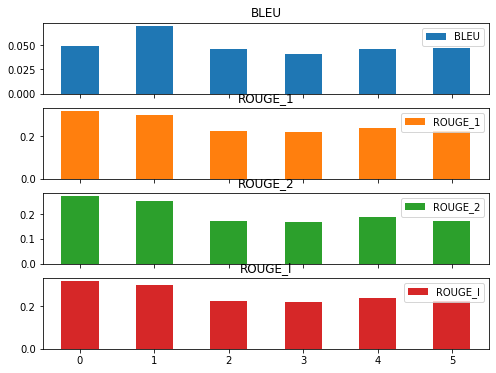

In [ ]:
df.iloc[:6].plot.bar(rot=0, subplots=True, figsize=(8, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfba576150>,
      dtype=object)

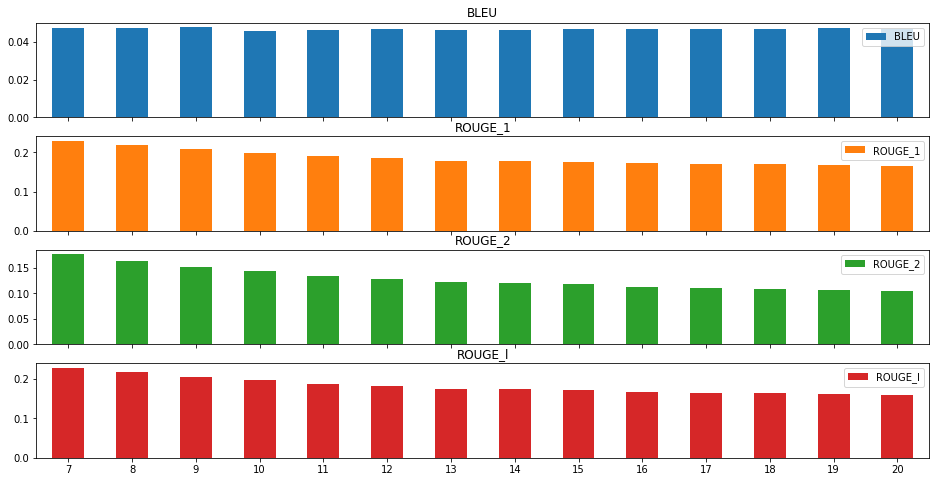

In [ ]:
df.iloc[7:].plot.bar(rot=0, subplots=True, figsize=(16, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfb88a6650>,
      dtype=object)

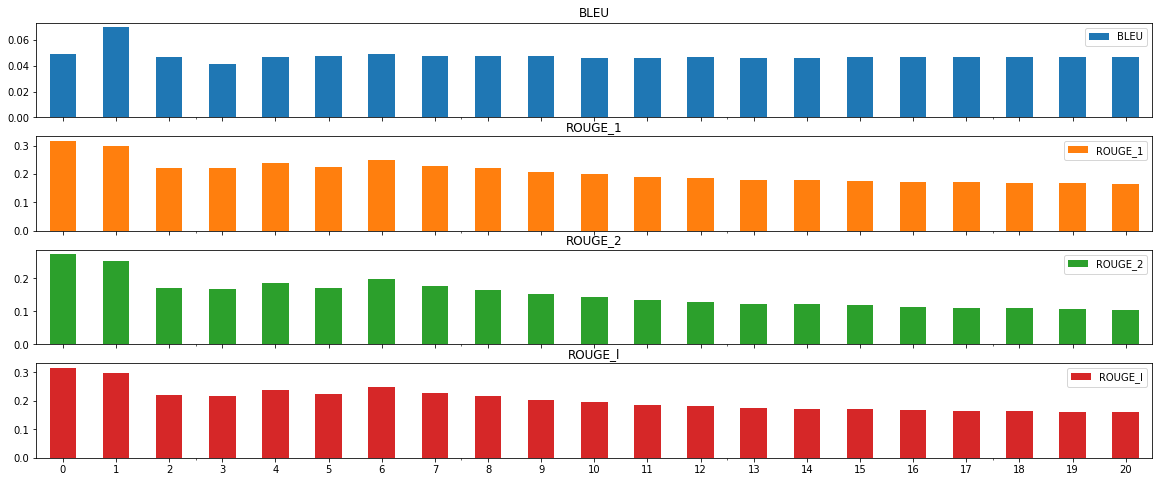

In [ ]:
df.plot.bar(rot=0, subplots=True, figsize=(20, 8))